# Personality Prediction Framework (v2.1) - with hyperparameter tuning

Developed by: R.T.R Jayasekara

## Required Libraries

In [1]:
import pandas
import numpy
import os
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [2]:
from sklearn.model_selection import GridSearchCV
import warnings

In [3]:
# import nltk
# nltk.download('vader_lexicon')

## Preprocessor

In order to work with text data, it is important to transform the raw text into a form that can be understood and used by Machine Learning algorithms, this is called preprocessing.

In [4]:
if __name__ == "__main__":
    status_data = pandas.read_csv("datasets/mypersonality_final.csv")

    NEG_INDEX = 2
    POS_INDEX = 3
    NEU_INDEX = 4
    COMP_INDEX = 5

    # Annotate the status with sentiment scores
    # From nltk.sentiment.vader corpus
    if not os.path.isfile("datasets/mypersonality_cleaned.csv"):
        status_data.insert(NEG_INDEX, "sentiNEG", 0)
        status_data.insert(POS_INDEX, "sentiPOS", 0)
        status_data.insert(NEU_INDEX, "sentiNEU", 0)
        status_data.insert(COMP_INDEX, "sentiCOMPOUND", 0)

        sid = SentimentIntensityAnalyzer()
        count = 0
        for row in status_data.itertuples():
            """
            pos: positive
            neg: negative
            neu: neutral
            compound: aggregated score for the sentence
            """
            ss = sid.polarity_scores(row.STATUS)
            status_data.iloc[count, NEG_INDEX] = ss["neg"]
            status_data.iloc[count, POS_INDEX] = ss["pos"]
            status_data.iloc[count, NEU_INDEX] = ss["neu"]
            status_data.iloc[count, COMP_INDEX] = ss["compound"]
            count += 1

        status_data.to_csv("datasets/mypersonality_cleaned.csv")
    else:
        status_data = pandas.read_csv("datasets/mypersonality_cleaned.csv")

In [5]:
# Drop NAs
status_data = status_data.dropna()

# We drop columns which give us a score for personality type
status_data = status_data.drop(['STATUS', '#AUTHID', 'sEXT', 'sNEU', 'sAGR',
                                    'sCON', 'sOPN', 'DATE'], axis=1)

# Drop non-normalized scores of Brokerage and Betweenness
status_data = status_data.drop(['BROKERAGE', 'BETWEENNESS', 'NBROKERAGE',
                                    'NBETWEENNESS', 'DENSITY', 'TRANSITIVITY', 'NETWORKSIZE'], axis=1)

In [6]:
status_data.head(10)

,Unnamed: 0,sentiNEG,sentiPOS,sentiNEU,sentiCOMPOUND,cEXT,cNEU,cAGR,cCON,cOPN
0,0,0.000,0.412,0.588,0.4215,n,y,n,n,y
1,1,0.167,0.000,0.833,-0.3412,n,y,n,n,y
2,2,0.195,0.278,0.527,0.6280,n,y,n,n,y
3,3,0.000,0.259,0.741,0.4215,n,y,n,n,y
4,4,0.000,0.592,0.408,0.4404,n,y,n,n,y
5,5,0.000,0.000,1.000,0.0000,n,y,n,n,y
6,6,0.000,0.515,0.485,0.8916,n,y,n,n,y
7,7,0.000,0.000,1.000,0.0000,n,y,n,n,y
8,8,0.188,0.053,0.759,-0.6249,n,y,n,n,y
9,9,0.000,0.323,0.677,0.7351,n,y,n,n,y


In [7]:
# Change the name of first row to "rowID"
new_columns = status_data.columns.values
new_columns[0] = "rowID"
status_data.columns = new_columns

# Put the columns to be predicted, at the end
cols = status_data.columns.tolist()
cols = cols[:5] + cols[5:10]
status_data = status_data[cols]

In [8]:
status_data.head(10)

,rowID,sentiNEG,sentiPOS,sentiNEU,sentiCOMPOUND,cEXT,cNEU,cAGR,cCON,cOPN
0,0,0.000,0.412,0.588,0.4215,n,y,n,n,y
1,1,0.167,0.000,0.833,-0.3412,n,y,n,n,y
2,2,0.195,0.278,0.527,0.6280,n,y,n,n,y
3,3,0.000,0.259,0.741,0.4215,n,y,n,n,y
4,4,0.000,0.592,0.408,0.4404,n,y,n,n,y
5,5,0.000,0.000,1.000,0.0000,n,y,n,n,y
6,6,0.000,0.515,0.485,0.8916,n,y,n,n,y
7,7,0.000,0.000,1.000,0.0000,n,y,n,n,y
8,8,0.188,0.053,0.759,-0.6249,n,y,n,n,y
9,9,0.000,0.323,0.677,0.7351,n,y,n,n,y


In [9]:
# 'y' for 1 and 'n' for 0
features = ['cEXT', 'cNEU', 'cOPN', 'cAGR', 'cCON']
for feature in features:
    status_data[feature] = status_data[feature].map({'y': 1.0, 'n': 0.0}).astype(int)

## Data Visualization

In [10]:
cOPN_counts = status_data['cOPN'].value_counts()
print(cOPN_counts)

cCON_counts = status_data['cCON'].value_counts()
print(cCON_counts)

cEXT_counts = status_data['cEXT'].value_counts()
print(cEXT_counts)

cAGR_counts = status_data['cAGR'].value_counts()
print(cAGR_counts)

cNEU_counts = status_data['cNEU'].value_counts()
print(cNEU_counts)

1    7369
0    2547
Name: cOPN, dtype: int64
0    5361
1    4555
Name: cCON, dtype: int64
0    5707
1    4209
Name: cEXT, dtype: int64
1    5267
0    4649
Name: cAGR, dtype: int64
0    6199
1    3717
Name: cNEU, dtype: int64


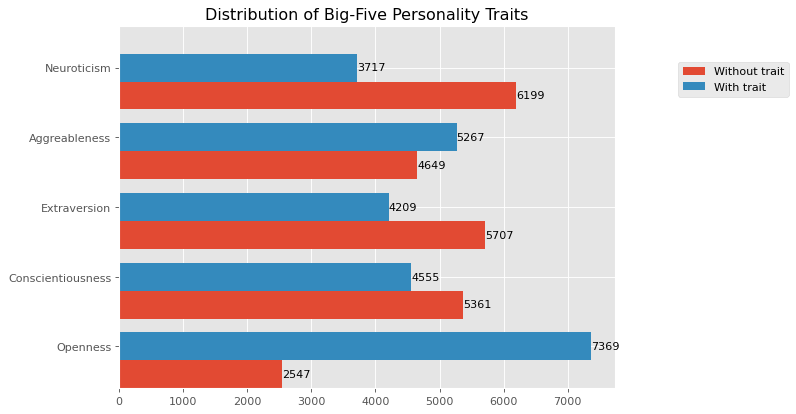

In [11]:
traits = ['Openness', 'Conscientiousness', 'Extraversion', 'Aggreableness', 'Neuroticism']
with_trait_counts = [cOPN_counts[1], cCON_counts[1], cEXT_counts[1], cAGR_counts[1], cNEU_counts[1]]
without_trait_counts = [cOPN_counts[0], cCON_counts[0], cEXT_counts[0], cAGR_counts[0], cNEU_counts[0]]

traits_df = pandas.DataFrame({'with_trait_counts': with_trait_counts, 
                              'without_trait_counts': without_trait_counts,
                              'traits': traits})
ind = numpy.arange(len(traits_df))
width = 0.4

fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
ax.barh(ind, traits_df.without_trait_counts, width, label='Without trait')
ax.barh(ind + width, traits_df.with_trait_counts, width, label='With trait')
ax.set(yticks=ind + width, yticklabels=traits_df.traits, ylim=[2*width - 1, len(traits_df)])
ax.legend(bbox_to_anchor=(1.35, 0.9), loc='upper right', borderaxespad=0)
ax.bar_label(ax.containers[0], label_type='edge')
ax.bar_label(ax.containers[1], label_type='edge')
plt.title('Distribution of Big-Five Personality Traits')
plt.show()


# Machine Learning

In [12]:
# Split into training and test data: 75% and 25%
train_data, test_data = train_test_split(status_data, test_size=0.25)

In [13]:
train_OPN = train_data[['rowID','sentiNEG', 'sentiPOS', 'sentiNEU', 'sentiCOMPOUND', 'cOPN']].values
train_CON = train_data[['rowID','sentiNEG', 'sentiPOS', 'sentiNEU', 'sentiCOMPOUND', 'cCON']].values
train_EXT = train_data[['rowID','sentiNEG', 'sentiPOS', 'sentiNEU', 'sentiCOMPOUND', 'cEXT']].values
train_AGR = train_data[['rowID','sentiNEG', 'sentiPOS', 'sentiNEU', 'sentiCOMPOUND', 'cAGR']].values
train_NEU = train_data[['rowID','sentiNEG', 'sentiPOS', 'sentiNEU', 'sentiCOMPOUND', 'cNEU']].values

test = test_data.values

In [14]:
def print_classification_reports(output_model_OPN, output_model_CON, output_model_EXT, output_model_AGR, output_model_NEU):
    print('Openness---')
    print(classification_report(test_data.cOPN, output_model_OPN))

    print('Conscientiousness---')
    print(classification_report(test_data.cCON, output_model_CON))

    print('Extraversion---')
    print(classification_report(test_data.cEXT, output_model_EXT))

    print('Aggreableness---')
    print(classification_report(test_data.cAGR, output_model_AGR))

    print('Neuroticism---')
    print(classification_report(test_data.cNEU, output_model_NEU))

In [15]:
def claculate_accuracy_scores(output_model_OPN, output_model_CON, output_model_EXT, output_model_AGR, output_model_NEU):
    model_accuracy = {
        'accuracy_opn': accuracy_score(test_data.cOPN, output_model_OPN),
        'accuracy_con': accuracy_score(test_data.cCON, output_model_CON),
        'accuracy_ext': accuracy_score(test_data.cEXT, output_model_EXT),
        'accuracy_agr': accuracy_score(test_data.cAGR, output_model_AGR),
        'accuracy_neu':accuracy_score(test_data.cNEU, output_model_NEU)
    }
    
    return model_accuracy

## Logistic Regression (LR)

In [16]:
warnings.filterwarnings('ignore')

# parameter grid
parameters_lr = {
    'penalty' : ['l1', 'l2'], 
    'C'       : numpy.logspace(-4, 4, 20),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
    'max_iter' : [50, 100, 1000, 2500, 5000]
}

In [17]:
# Build LR classifiers for each personality trait with hyperparameter tuning
model_LR_OPN = GridSearchCV(LogisticRegression(), param_grid = parameters_lr, scoring='accuracy', cv=5)
model_LR_OPN = model_LR_OPN.fit(train_OPN[0:, 1:5], train_OPN[0:, 5])
print("\n model_LR_OPN: best estimator across ALL searched params:\n",model_LR_OPN.best_estimator_)
print("\n model_LR_OPN: best parameters across ALL searched params:\n",model_LR_OPN.best_params_)

model_LR_CON = GridSearchCV(LogisticRegression(), param_grid = parameters_lr, scoring='accuracy', cv=5)
model_LR_CON = model_LR_CON.fit(train_CON[0:, 1:5], train_CON[0:, 5])
print("\n model_LR_CON: best estimator across ALL searched params:\n",model_LR_CON.best_estimator_)
print("\n model_LR_CON: best parameters across ALL searched params:\n",model_LR_CON.best_params_)

model_LR_EXT = GridSearchCV(LogisticRegression(), param_grid = parameters_lr, scoring='accuracy', cv=5)
model_LR_EXT = model_LR_EXT.fit(train_EXT[0:, 1:5], train_EXT[0:, 5])
print("\n model_LR_EXT: best estimator across ALL searched params:\n",model_LR_EXT.best_estimator_)
print("\n model_LR_EXT: best parameters across ALL searched params:\n",model_LR_EXT.best_params_)

model_LR_AGR = GridSearchCV(LogisticRegression(), param_grid = parameters_lr, scoring='accuracy', cv=5)
model_LR_AGR = model_LR_AGR.fit(train_AGR[0:, 1:5], train_AGR[0:, 5])
print("\n model_LR_AGR: best estimator across ALL searched params:\n",model_LR_AGR.best_estimator_)
print("\n model_LR_AGR: best parameters across ALL searched params:\n",model_LR_AGR.best_params_)

model_LR_NEU = GridSearchCV(LogisticRegression(), param_grid = parameters_lr, scoring='roc_auc', cv=5)
model_LR_NEU = model_LR_NEU.fit(train_NEU[0:, 1:5], train_NEU[0:, 5])
print("\n model_LR_NEU: best estimator across ALL searched params:\n",model_LR_NEU.best_estimator_)
print("\n model_LR_NEU: best parameters across ALL searched params:\n",model_LR_NEU.best_params_)


 model_LR_OPN: best estimator across ALL searched params:
 LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=50,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

 model_LR_OPN: best parameters across ALL searched params:
 {'C': 0.0001, 'max_iter': 50, 'penalty': 'l2', 'solver': 'newton-cg'}

 model_LR_CON: best estimator across ALL searched params:
 LogisticRegression(C=545.5594781168514, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

 model_LR_CON: best parameters across ALL searched params:
 {'C': 545.55

In [18]:
# Predict
output_LR_OPN = model_LR_OPN.predict(test[:, 1:5])
output_LR_CON = model_LR_CON.predict(test[:, 1:5])
output_LR_EXT = model_LR_EXT.predict(test[:, 1:5])
output_LR_AGR = model_LR_AGR.predict(test[:, 1:5])
output_LR_NEU = model_LR_NEU.predict(test[:, 1:5])

In [19]:
print_classification_reports(output_LR_OPN, output_LR_CON, output_LR_EXT, output_LR_AGR, output_LR_NEU)

Openness---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       656
           1       0.74      1.00      0.85      1823

    accuracy                           0.74      2479
   macro avg       0.37      0.50      0.42      2479
weighted avg       0.54      0.74      0.62      2479

Conscientiousness---
              precision    recall  f1-score   support

           0       0.55      1.00      0.71      1360
           1       0.00      0.00      0.00      1119

    accuracy                           0.55      2479
   macro avg       0.27      0.50      0.35      2479
weighted avg       0.30      0.55      0.39      2479

Extraversion---
              precision    recall  f1-score   support

           0       0.60      1.00      0.75      1477
           1       0.00      0.00      0.00      1002

    accuracy                           0.60      2479
   macro avg       0.30      0.50      0.37      2479
weighted avg       0.35  

In [20]:
lr_model_accuracy = claculate_accuracy_scores(output_LR_OPN, output_LR_CON, output_LR_EXT, output_LR_AGR, output_LR_NEU)
lr_model_accuracy

{'accuracy_opn': 0.7353771682129892,
 'accuracy_con': 0.5482049213392497,
 'accuracy_ext': 0.5954013715207745,
 'accuracy_agr': 0.5296490520371118,
 'accuracy_neu': 0.6163775716014522}

## K-Nearest Neighbors (KNN)

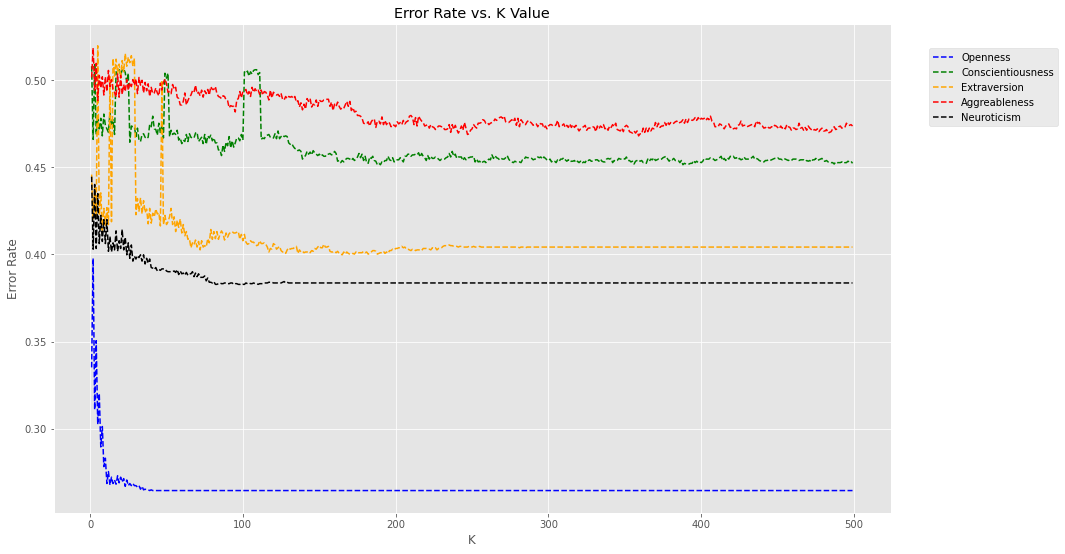

In [21]:
# Elbow method to determine the optimal K (n_neighbors)
error_rate_opn = []
error_rate_con = []
error_rate_ext = []
error_rate_agr = []
error_rate_neu = []

for i in range(1, 500):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(train_OPN[0:, 1:5], train_OPN[0:, 5])
    pred_i = knn.predict(test[0:, 1:5])
    error_rate_opn.append(numpy.mean(pred_i != test_data['cOPN']))
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(train_CON[0:, 1:5], train_CON[0:, 5])
    pred_i = knn.predict(test[0:, 1:5])
    error_rate_con.append(numpy.mean(pred_i != test_data['cCON']))
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(train_EXT[0:, 1:5], train_EXT[0:, 5])
    pred_i = knn.predict(test[0:, 1:5])
    error_rate_ext.append(numpy.mean(pred_i != test_data['cEXT']))
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(train_AGR[0:, 1:5], train_AGR[0:, 5])
    pred_i = knn.predict(test[0:, 1:5])
    error_rate_agr.append(numpy.mean(pred_i != test_data['cAGR']))
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(train_NEU[0:, 1:5], train_NEU[0:, 5])
    pred_i = knn.predict(test[0:, 1:5])
    error_rate_neu.append(numpy.mean(pred_i != test_data['cNEU']))

# Plotting a Line graphs of the error rate
plt.figure(figsize=(15,9))
plt.plot(range(1, 500), error_rate_opn, color='blue', linestyle='dashed', label='Openness')
plt.plot(range(1, 500), error_rate_con, color='green', linestyle='dashed', label='Conscientiousness')
plt.plot(range(1, 500), error_rate_ext, color='orange', linestyle='dashed', label='Extraversion')
plt.plot(range(1, 500), error_rate_agr, color='red', linestyle='dashed', label='Aggreableness')
plt.plot(range(1, 500), error_rate_neu, color='black', linestyle='dashed', label='Neuroticism')
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.legend(bbox_to_anchor=(1.2, 0.95), loc='upper right', borderaxespad=0)
plt.show()

In [22]:
# Optimal K
n_neighbors_opn = 50
n_neighbors_con = 300
n_neighbors_ext = 250
n_neighbors_agr = 200
n_neighbors_neu = 100

In [23]:
# Lists of hyperparameters
leaf_size = list(range(1, 75))
p=[1, 2]
weights = ['uniform', 'distance'],
metric = ['minkowski', 'euclidean', 'manhattan']

# Hyperparameters dictionary
hyperparameters = dict(leaf_size=leaf_size, p=p, metric=metric)

In [24]:
# Build KNN classifiers for each personality trait with hyperparameter tuning
model_KNN_OPN = GridSearchCV(KNeighborsClassifier(n_neighbors=n_neighbors_opn), hyperparameters, scoring='accuracy', cv=10)
model_KNN_OPN = model_KNN_OPN.fit(train_OPN[0:, 1:5], train_OPN[0:, 5])
print("\n model_KNN_OPN: best estimator across ALL searched params:\n",model_KNN_OPN.best_estimator_)
print("\n model_KNN_OPN: best parameters across ALL searched params:\n",model_KNN_OPN.best_params_)

model_KNN_CON = GridSearchCV(KNeighborsClassifier(n_neighbors=n_neighbors_con), hyperparameters, scoring='accuracy', cv=10)
model_KNN_CON = model_KNN_CON.fit(train_CON[0:, 1:5], train_CON[0:, 5])
print("\n model_KNN_CON: best estimator across ALL searched params:\n",model_KNN_CON.best_estimator_)
print("\n model_KNN_CON: best parameters across ALL searched params:\n",model_KNN_CON.best_params_)

model_KNN_EXT = GridSearchCV(KNeighborsClassifier(n_neighbors=n_neighbors_ext), hyperparameters, scoring='accuracy', cv=10)
model_KNN_EXT = model_KNN_EXT.fit(train_EXT[0:, 1:5], train_EXT[0:, 5])
print("\n model_KNN_EXT: best estimator across ALL searched params:\n",model_KNN_EXT.best_estimator_)
print("\n model_KNN_EXT: best parameters across ALL searched params:\n",model_KNN_EXT.best_params_)

model_KNN_AGR = GridSearchCV(KNeighborsClassifier(n_neighbors=n_neighbors_agr), hyperparameters, scoring='accuracy', cv=10)
model_KNN_AGR = model_KNN_AGR.fit(train_AGR[0:, 1:5], train_AGR[0:, 5])
print("\n model_KNN_AGR: best estimator across ALL searched params:\n",model_KNN_AGR.best_estimator_)
print("\n model_KNN_AGR: best parameters across ALL searched params:\n",model_KNN_AGR.best_params_)

model_KNN_NEU = GridSearchCV(KNeighborsClassifier(n_neighbors=n_neighbors_neu), hyperparameters, scoring='accuracy', cv=10)
model_KNN_NEU = model_KNN_NEU.fit(train_NEU[0:, 1:5], train_NEU[0:, 5])
print("\n model_KNN_NEU: best estimator across ALL searched params:\n",model_KNN_NEU.best_estimator_)
print("\n model_KNN_NEU: best parameters across ALL searched params:\n",model_KNN_NEU.best_params_)


 model_KNN_OPN: best estimator across ALL searched params:
 KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=1,
                     weights='uniform')

 model_KNN_OPN: best parameters across ALL searched params:
 {'leaf_size': 1, 'metric': 'minkowski', 'p': 1}

 model_KNN_CON: best estimator across ALL searched params:
 KNeighborsClassifier(algorithm='auto', leaf_size=27, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=300, p=2,
                     weights='uniform')

 model_KNN_CON: best parameters across ALL searched params:
 {'leaf_size': 27, 'metric': 'minkowski', 'p': 2}

 model_KNN_EXT: best estimator across ALL searched params:
 KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=250, p=1,
                     weights='uniform')

 model_KNN_EXT: best parameters

In [25]:
# Predict
output_KNN_OPN = model_KNN_OPN.predict(test[:, 1:5])
output_KNN_CON = model_KNN_CON.predict(test[:, 1:5])
output_KNN_EXT = model_KNN_EXT.predict(test[:, 1:5])
output_KNN_AGR = model_KNN_AGR.predict(test[:, 1:5])
output_KNN_NEU = model_KNN_NEU.predict(test[:, 1:5])

In [26]:
print_classification_reports(output_KNN_OPN, output_KNN_CON, output_KNN_EXT, output_KNN_AGR, output_KNN_NEU)

Openness---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       656
           1       0.74      1.00      0.85      1823

    accuracy                           0.74      2479
   macro avg       0.37      0.50      0.42      2479
weighted avg       0.54      0.74      0.62      2479

Conscientiousness---
              precision    recall  f1-score   support

           0       0.55      0.97      0.70      1360
           1       0.44      0.02      0.05      1119

    accuracy                           0.55      2479
   macro avg       0.50      0.50      0.37      2479
weighted avg       0.50      0.55      0.41      2479

Extraversion---
              precision    recall  f1-score   support

           0       0.60      1.00      0.75      1477
           1       0.67      0.00      0.00      1002

    accuracy                           0.60      2479
   macro avg       0.63      0.50      0.38      2479
weighted avg       0.62  

In [27]:
knn_model_accuracy = claculate_accuracy_scores(output_KNN_OPN, output_KNN_CON, output_KNN_EXT, output_KNN_AGR, output_KNN_NEU)
knn_model_accuracy

{'accuracy_opn': 0.7353771682129892,
 'accuracy_con': 0.5457845905607099,
 'accuracy_ext': 0.5962081484469545,
 'accuracy_agr': 0.5260185558693021,
 'accuracy_neu': 0.6155707946752723}

## Random Forest (RF)

In [28]:
params = {
    'max_depth': list(range(1, 25)),
    'min_samples_leaf': [5, 10, 20, 50, 100, 200],
    'n_estimators': [10, 25, 30, 50, 100, 150, 200, 250, 300, 400, 500],
    'max_depth': [int(x) for x in numpy.linspace(10, 110, num = 11)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [29]:
# Build RF classifiers for each personality trait with hyperparameter tuning
model_RF_OPN = GridSearchCV(estimator=RandomForestClassifier(random_state=42, n_jobs=-1), param_grid=params, cv = 4, n_jobs=-1, verbose=1, scoring="accuracy")
model_RF_OPN = model_RF_OPN.fit(train_OPN[0:, 1:5], train_OPN[0:, 5])
print("\n model_RF_OPN: best estimator across ALL searched params:\n",model_RF_OPN.best_estimator_)
print("\n model_RF_OPN: best parameters across ALL searched params:\n",model_RF_OPN.best_params_)

model_RF_CON = GridSearchCV(estimator=RandomForestClassifier(random_state=42, n_jobs=-1), param_grid=params, cv = 4, n_jobs=-1, verbose=1, scoring="accuracy")
model_RF_CON = model_RF_CON.fit(train_CON[0:, 1:5], train_CON[0:, 5])
print("\n model_RF_CON: best estimator across ALL searched params:\n",model_RF_CON.best_estimator_)
print("\n model_RF_CON: best parameters across ALL searched params:\n",model_RF_CON.best_params_)

model_RF_EXT = GridSearchCV(estimator=RandomForestClassifier(random_state=42, n_jobs=-1), param_grid=params, cv = 4, n_jobs=-1, verbose=1, scoring="accuracy")
model_RF_EXT = model_RF_EXT.fit(train_EXT[0:, 1:5], train_EXT[0:, 5])
print("\n model_RF_EXT: best estimator across ALL searched params:\n",model_RF_EXT.best_estimator_)
print("\n model_RF_EXT: best parameters across ALL searched params:\n",model_RF_EXT.best_params_)

model_RF_AGR = GridSearchCV(estimator=RandomForestClassifier(random_state=42, n_jobs=-1), param_grid=params, cv = 4, n_jobs=-1, verbose=1, scoring="accuracy")
model_RF_AGR = model_RF_AGR.fit(train_AGR[0:, 1:5], train_AGR[0:, 5])
print("\n model_RF_AGR: best estimator across ALL searched params:\n",model_RF_AGR.best_estimator_)
print("\n model_RF_AGR: best parameters across ALL searched params:\n",model_RF_AGR.best_params_)

model_RF_NEU = GridSearchCV(estimator=RandomForestClassifier(random_state=42, n_jobs=-1), param_grid=params, cv = 4, n_jobs=-1, verbose=1, scoring="accuracy")
model_RF_NEU = model_RF_NEU.fit(train_NEU[0:, 1:5], train_NEU[0:, 5])
print("\n model_RF_NEU: best estimator across ALL searched params:\n",model_RF_NEU.best_estimator_)
print("\n model_RF_NEU: best parameters across ALL searched params:\n",model_RF_NEU.best_params_)

Fitting 4 folds for each of 1089 candidates, totalling 4356 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 4356 out of 4356 | elapsed: 19.6min finished



 model_RF_OPN: best estimator across ALL searched params:
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

 model_RF_OPN: best parameters across ALL searched params:
 {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
Fitting 4 folds for each of 1089 candidates, totalling 4356 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:   55.0s
[Parallel(n_jobs=-1)]: Done 450 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 800 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1250 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 1800 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 2450 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done 4050 tasks      | elapsed: 27.3min
[Parallel(n_jobs=-1)]: Done 4356 out of 4356 | elapsed: 29.3min finished



 model_RF_CON: best estimator across ALL searched params:
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

 model_RF_CON: best parameters across ALL searched params:
 {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Fitting 4 folds for each of 1089 candidates, totalling 4356 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:   52.6s
[Parallel(n_jobs=-1)]: Done 450 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 800 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1250 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 1800 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 2450 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 4050 tasks      | elapsed: 26.8min
[Parallel(n_jobs=-1)]: Done 4356 out of 4356 | elapsed: 29.0min finished



 model_RF_EXT: best estimator across ALL searched params:
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

 model_RF_EXT: best parameters across ALL searched params:
 {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Fitting 4 folds for each of 1089 candidates, totalling 4356 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 14.5min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 27.0min
[Parallel(n_jobs=-1)]: Done 4356 out of 4356 | elapsed: 28.5min finished



 model_RF_AGR: best estimator across ALL searched params:
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

 model_RF_AGR: best parameters across ALL searched params:
 {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150}
Fitting 4 folds for each of 1089 candidates, totalling 4356 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 450 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 800 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1250 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1800 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 2450 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 4050 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 4356 out of 4356 | elapsed: 19.0min finished



 model_RF_NEU: best estimator across ALL searched params:
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

 model_RF_NEU: best parameters across ALL searched params:
 {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 400}


In [30]:
# Predict
output_RF_OPN = model_RF_OPN.predict(test[:, 1:5])
output_RF_CON = model_RF_CON.predict(test[:, 1:5])
output_RF_EXT = model_RF_EXT.predict(test[:, 1:5])
output_RF_AGR = model_RF_AGR.predict(test[:, 1:5])
output_RF_NEU = model_RF_NEU.predict(test[:, 1:5])

In [31]:
print_classification_reports(output_RF_OPN, output_RF_CON, output_RF_EXT, output_RF_AGR, output_RF_NEU)

Openness---
              precision    recall  f1-score   support

           0       0.33      0.00      0.01       656
           1       0.74      1.00      0.85      1823

    accuracy                           0.73      2479
   macro avg       0.53      0.50      0.43      2479
weighted avg       0.63      0.73      0.62      2479

Conscientiousness---
              precision    recall  f1-score   support

           0       0.55      0.88      0.68      1360
           1       0.47      0.13      0.21      1119

    accuracy                           0.54      2479
   macro avg       0.51      0.51      0.44      2479
weighted avg       0.52      0.54      0.46      2479

Extraversion---
              precision    recall  f1-score   support

           0       0.60      0.94      0.73      1477
           1       0.47      0.08      0.14      1002

    accuracy                           0.59      2479
   macro avg       0.53      0.51      0.44      2479
weighted avg       0.55  

In [32]:
rf_model_accuracy = claculate_accuracy_scores(output_RF_OPN, output_RF_CON, output_RF_EXT, output_RF_AGR, output_RF_NEU)
rf_model_accuracy

{'accuracy_opn': 0.7341670028237193,
 'accuracy_con': 0.5413473174667205,
 'accuracy_ext': 0.591367486889875,
 'accuracy_agr': 0.5086728519564341,
 'accuracy_neu': 0.608309802339653}

## Support Vector Machine (SVM)

In [33]:
param_grid = {
    'C': [0.1,1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

In [34]:
# Build SVM classifiers for each personality trait with hyperparameter tuning
model_SVM_OPN = GridSearchCV(SVC(), param_grid, refit=True, scoring='accuracy', verbose=2)
model_SVM_OPN = model_SVM_OPN.fit(train_OPN[0:, 1:5], train_OPN[0:, 5])
print("\n model_SVM_OPN: best estimator across ALL searched params:\n",model_SVM_OPN.best_estimator_)
print("\n model_SVM_OPN: best parameters across ALL searched params:\n",model_SVM_OPN.best_params_)

model_SVM_CON = GridSearchCV(SVC(), param_grid, refit=True, scoring='accuracy', verbose=2)
model_SVM_CON = model_SVM_CON.fit(train_CON[0:, 1:5], train_CON[0:, 5])
print("\n model_SVM_CON: best estimator across ALL searched params:\n",model_SVM_CON.best_estimator_)
print("\n model_SVM_CON: best parameters across ALL searched params:\n",model_SVM_CON.best_params_)

model_SVM_EXT = GridSearchCV(SVC(), param_grid, refit=True, scoring='accuracy', verbose=2)
model_SVM_EXT = model_SVM_EXT.fit(train_EXT[0:, 1:5], train_EXT[0:, 5])
print("\n model_SVM_EXT: best estimator across ALL searched params:\n",model_SVM_EXT.best_estimator_)
print("\n model_SVM_EXT: best parameters across ALL searched params:\n",model_SVM_EXT.best_params_)

model_SVM_AGR = GridSearchCV(SVC(), param_grid, refit=True, scoring='accuracy', verbose=2)
model_SVM_AGR = model_SVM_AGR.fit(train_AGR[0:, 1:5], train_AGR[0:, 5])
print("\n model_SVM_AGR: best estimator across ALL searched params:\n",model_SVM_AGR.best_estimator_)
print("\n model_SVM_AGR: best parameters across ALL searched params:\n",model_SVM_AGR.best_params_)

model_SVM_NEU = GridSearchCV(SVC(), param_grid, refit=True, scoring='accuracy', verbose=2)
model_SVM_NEU = model_SVM_NEU.fit(train_NEU[0:, 1:5], train_NEU[0:, 5])
print("\n model_SVM_NEU: best estimator across ALL searched params:\n",model_SVM_NEU.best_estimator_)
print("\n model_SVM_NEU: best parameters across ALL searched params:\n",model_SVM_NEU.best_params_)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.6s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.6s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.6s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.6s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.6s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.4s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.4s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.4s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] .

[CV] ............... C=0.1, gamma=0.001, kernel=sigmoid, total=   0.5s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=   0.6s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=   0.5s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=   0.5s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=   0.6s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=   0.5s
[CV] C=0.1, gamma=0.0001, kernel=poly ................................
[CV] ................. C=0.1, gamma=0.0001, kernel=poly, total=   0.3s
[CV] C=0.1, gamma=0.0001, kernel=poly ................................
[CV] .

[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=   0.5s
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=   0.5s
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=   0.5s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.6s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.5s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.5s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.5s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] .

[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   1.1s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   1.6s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   1.1s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   1.1s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   1.0s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=   0.5s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=   0.5s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] .

[CV] ...................... C=100, gamma=1, kernel=poly, total=   3.0s
[CV] C=100, gamma=1, kernel=poly .....................................
[CV] ...................... C=100, gamma=1, kernel=poly, total=   5.2s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=   0.5s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=   0.9s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=   0.9s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=   0.9s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=   1.0s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] ................. C=100, gamma=0.0001, kernel=poly, total=   0.3s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] ................. C=100, gamma=0.0001, kernel=poly, total=   0.3s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] ................. C=100, gamma=0.0001, kernel=poly, total=   0.3s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] ................. C=100, gamma=0.0001, kernel=poly, total=   0.3s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .............. C=100, gamma=0.0001, kernel=sigmoid, total=   0.4s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .............. C=100, gamma=0.0001, kernel=sigmoid, total=   0.4s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .............. C=100, gamma=0.0001, kernel=sigmoid, total=   0.4s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .

[CV] .................. C=1000, gamma=0.001, kernel=rbf, total=   2.3s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=   0.3s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=   0.3s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=   0.3s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=   0.3s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=   0.3s
[CV] C=1000, gamma=0.001, kernel=sigmoid .............................
[CV] .............. C=1000, gamma=0.001, kernel=sigmoid, total=   0.4s
[CV] C=1000, gamma=0.001, kernel=sigmoid .............................
[CV] .

[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed: 107.4min finished



 model_SVM_OPN: best estimator across ALL searched params:
 SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

 model_SVM_OPN: best parameters across ALL searched params:
 {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   1.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.9s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   1.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   1.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   1.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.7s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.6s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.7s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] .

[CV] ............... C=0.1, gamma=0.001, kernel=sigmoid, total=   0.9s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=   1.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=   1.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=   0.9s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=   0.9s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=   0.9s
[CV] C=0.1, gamma=0.0001, kernel=poly ................................
[CV] ................. C=0.1, gamma=0.0001, kernel=poly, total=   0.6s
[CV] C=0.1, gamma=0.0001, kernel=poly ................................
[CV] .

[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=   0.8s
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=   0.8s
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=   0.8s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   1.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   1.1s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.9s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.9s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] .

[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   1.2s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   1.1s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   1.2s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   1.2s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   1.2s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=   0.9s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=   0.9s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] .

[CV] ...................... C=100, gamma=1, kernel=poly, total=  19.1s
[CV] C=100, gamma=1, kernel=poly .....................................
[CV] ...................... C=100, gamma=1, kernel=poly, total=   2.5s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=   0.8s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=   0.9s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=   0.9s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=   0.9s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=   1.1s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] ................. C=100, gamma=0.0001, kernel=poly, total=   0.5s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] ................. C=100, gamma=0.0001, kernel=poly, total=   0.6s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] ................. C=100, gamma=0.0001, kernel=poly, total=   0.5s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] ................. C=100, gamma=0.0001, kernel=poly, total=   0.5s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .............. C=100, gamma=0.0001, kernel=sigmoid, total=   0.9s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .............. C=100, gamma=0.0001, kernel=sigmoid, total=   0.8s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .............. C=100, gamma=0.0001, kernel=sigmoid, total=   0.8s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .

[CV] .................. C=1000, gamma=0.001, kernel=rbf, total=   1.4s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=   0.5s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=   0.5s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=   0.5s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=   0.5s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=   0.5s
[CV] C=1000, gamma=0.001, kernel=sigmoid .............................
[CV] .............. C=1000, gamma=0.001, kernel=sigmoid, total=   0.8s
[CV] C=1000, gamma=0.001, kernel=sigmoid .............................
[CV] .

[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed: 24.4min finished



 model_SVM_CON: best estimator across ALL searched params:
 SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

 model_SVM_CON: best parameters across ALL searched params:
 {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.9s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.8s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.8s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.8s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.9s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.5s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.5s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.5s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] .

[CV] ............... C=0.1, gamma=0.001, kernel=sigmoid, total=   0.7s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=   0.8s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=   0.8s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=   0.9s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=   0.9s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=   0.9s
[CV] C=0.1, gamma=0.0001, kernel=poly ................................
[CV] ................. C=0.1, gamma=0.0001, kernel=poly, total=   0.5s
[CV] C=0.1, gamma=0.0001, kernel=poly ................................
[CV] .

[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=   0.7s
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=   0.7s
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=   0.7s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.8s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.8s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.8s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.8s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] .

[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   1.2s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   1.2s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   1.2s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   1.3s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   1.2s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=   0.9s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=   0.9s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] .

[CV] ...................... C=100, gamma=1, kernel=poly, total=   7.3s
[CV] C=100, gamma=1, kernel=poly .....................................
[CV] ...................... C=100, gamma=1, kernel=poly, total=   4.8s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=   1.1s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=   1.1s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=   1.1s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=   1.2s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=   1.1s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] ................. C=100, gamma=0.0001, kernel=poly, total=   0.5s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] ................. C=100, gamma=0.0001, kernel=poly, total=   0.6s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] ................. C=100, gamma=0.0001, kernel=poly, total=   0.6s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] ................. C=100, gamma=0.0001, kernel=poly, total=   0.6s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .............. C=100, gamma=0.0001, kernel=sigmoid, total=   0.9s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .............. C=100, gamma=0.0001, kernel=sigmoid, total=   0.8s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .............. C=100, gamma=0.0001, kernel=sigmoid, total=   0.8s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .

[CV] .................. C=1000, gamma=0.001, kernel=rbf, total=   1.6s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=   0.5s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=   0.6s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=   0.5s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=   0.5s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=   0.6s
[CV] C=1000, gamma=0.001, kernel=sigmoid .............................
[CV] .............. C=1000, gamma=0.001, kernel=sigmoid, total=   0.9s
[CV] C=1000, gamma=0.001, kernel=sigmoid .............................
[CV] .

[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed: 45.7min finished



 model_SVM_EXT: best estimator across ALL searched params:
 SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

 model_SVM_EXT: best parameters across ALL searched params:
 {'C': 1000, 'gamma': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   1.5s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   1.5s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   1.4s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   1.4s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   1.3s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   1.1s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   1.1s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   1.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] .

[CV] ............... C=0.1, gamma=0.001, kernel=sigmoid, total=   0.9s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=   1.1s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=   1.1s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=   1.1s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=   1.1s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=   1.0s
[CV] C=0.1, gamma=0.0001, kernel=poly ................................
[CV] ................. C=0.1, gamma=0.0001, kernel=poly, total=   0.6s
[CV] C=0.1, gamma=0.0001, kernel=poly ................................
[CV] .

[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=   0.9s
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=   0.9s
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=   1.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   1.1s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   1.2s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   1.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   1.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] .

[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   1.5s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   1.3s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   1.5s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   1.5s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   1.5s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=   1.6s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=   1.4s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] .

[CV] ...................... C=100, gamma=1, kernel=poly, total=  18.3s
[CV] C=100, gamma=1, kernel=poly .....................................
[CV] ...................... C=100, gamma=1, kernel=poly, total=  11.9s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=   1.2s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=   1.2s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=   1.1s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=   1.3s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=   1.3s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] ................. C=100, gamma=0.0001, kernel=poly, total=   0.7s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] ................. C=100, gamma=0.0001, kernel=poly, total=   0.6s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] ................. C=100, gamma=0.0001, kernel=poly, total=   0.6s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] ................. C=100, gamma=0.0001, kernel=poly, total=   0.7s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .............. C=100, gamma=0.0001, kernel=sigmoid, total=   1.0s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .............. C=100, gamma=0.0001, kernel=sigmoid, total=   1.0s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .............. C=100, gamma=0.0001, kernel=sigmoid, total=   0.9s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .

[CV] .................. C=1000, gamma=0.001, kernel=rbf, total=   2.1s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=   0.6s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=   0.6s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=   0.6s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=   0.7s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=   0.6s
[CV] C=1000, gamma=0.001, kernel=sigmoid .............................
[CV] .............. C=1000, gamma=0.001, kernel=sigmoid, total=   1.0s
[CV] C=1000, gamma=0.001, kernel=sigmoid .............................
[CV] .

[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed: 18.8min finished



 model_SVM_AGR: best estimator across ALL searched params:
 SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

 model_SVM_AGR: best parameters across ALL searched params:
 {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.9s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.9s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.9s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.8s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.8s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.5s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.5s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.5s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] .

[CV] ............... C=0.1, gamma=0.001, kernel=sigmoid, total=   0.7s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=   0.8s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=   0.9s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=   0.8s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=   0.8s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=   0.8s
[CV] C=0.1, gamma=0.0001, kernel=poly ................................
[CV] ................. C=0.1, gamma=0.0001, kernel=poly, total=   0.5s
[CV] C=0.1, gamma=0.0001, kernel=poly ................................
[CV] .

[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=   0.8s
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=   0.8s
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=   0.7s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.8s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.8s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.8s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   0.8s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] .

[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   1.0s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   1.1s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   1.0s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   0.9s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   0.9s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=   0.9s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=   0.9s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] .

[CV] ...................... C=100, gamma=1, kernel=poly, total=   3.5s
[CV] C=100, gamma=1, kernel=poly .....................................
[CV] ...................... C=100, gamma=1, kernel=poly, total=   3.1s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=   0.8s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=   0.8s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=   0.8s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=   0.9s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=   0.9s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] ................. C=100, gamma=0.0001, kernel=poly, total=   0.5s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] ................. C=100, gamma=0.0001, kernel=poly, total=   0.5s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] ................. C=100, gamma=0.0001, kernel=poly, total=   0.5s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] ................. C=100, gamma=0.0001, kernel=poly, total=   0.5s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .............. C=100, gamma=0.0001, kernel=sigmoid, total=   0.7s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .............. C=100, gamma=0.0001, kernel=sigmoid, total=   0.7s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .............. C=100, gamma=0.0001, kernel=sigmoid, total=   0.8s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .

[CV] .................. C=1000, gamma=0.001, kernel=rbf, total=   1.5s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=   0.4s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=   0.4s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=   0.4s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=   0.4s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=   0.4s
[CV] C=1000, gamma=0.001, kernel=sigmoid .............................
[CV] .............. C=1000, gamma=0.001, kernel=sigmoid, total=   0.7s
[CV] C=1000, gamma=0.001, kernel=sigmoid .............................
[CV] .

[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed: 56.7min finished



 model_SVM_NEU: best estimator across ALL searched params:
 SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

 model_SVM_NEU: best parameters across ALL searched params:
 {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}


In [35]:
# Predict
output_SVM_OPN = model_SVM_OPN.predict(test[:, 1:5])
output_SVM_CON = model_SVM_CON.predict(test[:, 1:5])
output_SVM_EXT = model_SVM_EXT.predict(test[:, 1:5])
output_SVM_AGR = model_SVM_AGR.predict(test[:, 1:5])
output_SVM_NEU = model_SVM_NEU.predict(test[:, 1:5])

In [36]:
print_classification_reports(output_SVM_OPN, output_SVM_CON, output_SVM_EXT, output_SVM_AGR, output_SVM_NEU)

Openness---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       656
           1       0.74      1.00      0.85      1823

    accuracy                           0.74      2479
   macro avg       0.37      0.50      0.42      2479
weighted avg       0.54      0.74      0.62      2479

Conscientiousness---
              precision    recall  f1-score   support

           0       0.55      1.00      0.71      1360
           1       0.00      0.00      0.00      1119

    accuracy                           0.55      2479
   macro avg       0.27      0.50      0.35      2479
weighted avg       0.30      0.55      0.39      2479

Extraversion---
              precision    recall  f1-score   support

           0       0.60      0.99      0.75      1477
           1       0.54      0.01      0.03      1002

    accuracy                           0.60      2479
   macro avg       0.57      0.50      0.39      2479
weighted avg       0.57  

In [37]:
svm_model_accuracy = claculate_accuracy_scores(output_SVM_OPN, output_SVM_CON, output_SVM_EXT, output_SVM_AGR, output_SVM_NEU)
svm_model_accuracy

{'accuracy_opn': 0.7353771682129892,
 'accuracy_con': 0.5486083098023397,
 'accuracy_ext': 0.5966115369100444,
 'accuracy_agr': 0.5264219443323921,
 'accuracy_neu': 0.6163775716014522}

## Gaussian Naive Bayes

In [38]:
param_grid = {
    'var_smoothing': numpy.logspace(0,-9, num=100)
}

In [39]:
# Build Naive Bayes classifiers for each personality trait with hyperparameter tuning
model_GNB_OPN = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, scoring='accuracy', verbose=1, cv=10, n_jobs=-1)
model_GNB_OPN = model_GNB_OPN.fit(train_OPN[0:, 1:5], train_OPN[0:, 5])
print("\n model_GNB_OPN: best estimator across ALL searched params:\n",model_GNB_OPN.best_estimator_)
print("\n model_GNB_OPN: best parameters across ALL searched params:\n",model_GNB_OPN.best_params_)

model_GNB_CON = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, scoring='accuracy', verbose=1, cv=10, n_jobs=-1)
model_GNB_CON = model_GNB_CON.fit(train_CON[0:, 1:5], train_CON[0:, 5])
print("\n model_GNB_CON: best estimator across ALL searched params:\n",model_GNB_CON.best_estimator_)
print("\n model_GNB_CON: best parameters across ALL searched params:\n",model_GNB_CON.best_params_)

model_GNB_EXT = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, scoring='accuracy', verbose=1, cv=10, n_jobs=-1)
model_GNB_EXT = model_GNB_EXT.fit(train_EXT[0:, 1:5], train_EXT[0:, 5])
print("\n model_GNB_EXT: best estimator across ALL searched params:\n",model_GNB_EXT.best_estimator_)
print("\n model_GNB_EXT: best parameters across ALL searched params:\n",model_GNB_EXT.best_params_)

model_GNB_AGR = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, scoring='accuracy', verbose=1, cv=10, n_jobs=-1)
model_GNB_AGR = model_GNB_AGR.fit(train_AGR[0:, 1:5], train_AGR[0:, 5])
print("\n model_GNB_AGR: best estimator across ALL searched params:\n",model_GNB_AGR.best_estimator_)
print("\n model_GNB_AGR: best parameters across ALL searched params:\n",model_GNB_AGR.best_params_)

model_GNB_NEU = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, scoring='accuracy', verbose=1, cv=10, n_jobs=-1)
model_GNB_NEU = model_GNB_NEU.fit(train_NEU[0:, 1:5], train_NEU[0:, 5])
print("\n model_GNB_NEU: best estimator across ALL searched params:\n",model_GNB_NEU.best_estimator_)
print("\n model_GNB_NEU: best parameters across ALL searched params:\n",model_GNB_NEU.best_params_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 740 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s



 model_GNB_OPN: best estimator across ALL searched params:
 GaussianNB(priors=None, var_smoothing=1.0)

 model_GNB_OPN: best parameters across ALL searched params:
 {'var_smoothing': 1.0}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done 856 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



 model_GNB_CON: best estimator across ALL searched params:
 GaussianNB(priors=None, var_smoothing=1.0)

 model_GNB_CON: best parameters across ALL searched params:
 {'var_smoothing': 1.0}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 856 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



 model_GNB_EXT: best estimator across ALL searched params:
 GaussianNB(priors=None, var_smoothing=1.0)

 model_GNB_EXT: best parameters across ALL searched params:
 {'var_smoothing': 1.0}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 856 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



 model_GNB_AGR: best estimator across ALL searched params:
 GaussianNB(priors=None, var_smoothing=0.43287612810830584)

 model_GNB_AGR: best parameters across ALL searched params:
 {'var_smoothing': 0.43287612810830584}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.0s



 model_GNB_NEU: best estimator across ALL searched params:
 GaussianNB(priors=None, var_smoothing=1.0)

 model_GNB_NEU: best parameters across ALL searched params:
 {'var_smoothing': 1.0}


[Parallel(n_jobs=-1)]: Done 856 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    0.8s finished


In [40]:
# Predict
output_GNB_OPN = model_GNB_OPN.predict(test[:, 1:5])
output_GNB_CON = model_GNB_CON.predict(test[:, 1:5])
output_GNB_EXT = model_GNB_EXT.predict(test[:, 1:5])
output_GNB_AGR = model_GNB_AGR.predict(test[:, 1:5])
output_GNB_NEU = model_GNB_NEU.predict(test[:, 1:5])

In [41]:
print_classification_reports(output_GNB_OPN, output_GNB_CON, output_GNB_EXT, output_GNB_AGR, output_GNB_NEU)

Openness---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       656
           1       0.74      1.00      0.85      1823

    accuracy                           0.74      2479
   macro avg       0.37      0.50      0.42      2479
weighted avg       0.54      0.74      0.62      2479

Conscientiousness---
              precision    recall  f1-score   support

           0       0.55      1.00      0.71      1360
           1       0.00      0.00      0.00      1119

    accuracy                           0.55      2479
   macro avg       0.27      0.50      0.35      2479
weighted avg       0.30      0.55      0.39      2479

Extraversion---
              precision    recall  f1-score   support

           0       0.60      1.00      0.75      1477
           1       0.00      0.00      0.00      1002

    accuracy                           0.60      2479
   macro avg       0.30      0.50      0.37      2479
weighted avg       0.35  

In [42]:
gnb_model_accuracy = claculate_accuracy_scores(output_GNB_OPN, output_GNB_CON, output_GNB_EXT, output_GNB_AGR, output_GNB_NEU)
gnb_model_accuracy

{'accuracy_opn': 0.7353771682129892,
 'accuracy_con': 0.5486083098023397,
 'accuracy_ext': 0.5958047599838645,
 'accuracy_agr': 0.5300524405002017,
 'accuracy_neu': 0.6163775716014522}

## Pickling the Models

In [43]:
# Pickling LR Models
with open('pickle_files/v2.1/ppf_lr_opn.pickle', 'wb') as files:
  pickle.dump(model_LR_OPN, files)

with open('pickle_files/v2.1/ppf_lr_con.pickle', 'wb') as files:
  pickle.dump(model_LR_CON, files)

with open('pickle_files/v2.1/ppf_lr_ext.pickle', 'wb') as files:
  pickle.dump(model_LR_EXT, files)

with open('pickle_files/v2.1/ppf_lr_agr.pickle', 'wb') as files:
  pickle.dump(model_LR_AGR, files)

with open('pickle_files/v2.1/ppf_lr_neu.pickle', 'wb') as files:
  pickle.dump(model_LR_NEU, files)

In [44]:
# Pickling KNN Models
with open('pickle_files/v2.1/ppf_knn_opn.pickle', 'wb') as files:
  pickle.dump(model_KNN_OPN, files)

with open('pickle_files/v2.1/ppf_knn_con.pickle', 'wb') as files:
  pickle.dump(model_KNN_CON, files)

with open('pickle_files/v2.1/ppf_knn_ext.pickle', 'wb') as files:
  pickle.dump(model_KNN_EXT, files)

with open('pickle_files/v2.1/ppf_knn_agr.pickle', 'wb') as files:
  pickle.dump(model_KNN_AGR, files)

with open('pickle_files/v2.1/ppf_knn_neu.pickle', 'wb') as files:
  pickle.dump(model_KNN_NEU, files)

In [45]:
# Pickling RF Models
with open('pickle_files/v2.1/ppf_rf_opn.pickle', 'wb') as files:
  pickle.dump(model_RF_OPN, files)

with open('pickle_files/v2.1/ppf_rf_con.pickle', 'wb') as files:
  pickle.dump(model_RF_CON, files)

with open('pickle_files/v2.1/ppf_rf_ext.pickle', 'wb') as files:
  pickle.dump(model_RF_EXT, files)

with open('pickle_files/v2.1/ppf_rf_agr.pickle', 'wb') as files:
  pickle.dump(model_RF_AGR, files)

with open('pickle_files/v2.1/ppf_rf_neu.pickle', 'wb') as files:
  pickle.dump(model_RF_NEU, files)

In [46]:
# Pickling SVM Models
with open('pickle_files/v2.1/ppf_svm_opn.pickle', 'wb') as files:
  pickle.dump(model_SVM_OPN, files)

with open('pickle_files/v2.1/ppf_svm_con.pickle', 'wb') as files:
  pickle.dump(model_SVM_CON, files)

with open('pickle_files/v2.1/ppf_svm_ext.pickle', 'wb') as files:
  pickle.dump(model_SVM_EXT, files)

with open('pickle_files/v2.1/ppf_svm_agr.pickle', 'wb') as files:
  pickle.dump(model_SVM_AGR, files)

with open('pickle_files/v2.1/ppf_svm_neu.pickle', 'wb') as files:
  pickle.dump(model_SVM_NEU, files)

In [47]:
# Pickling GNB Models
with open('pickle_files/v2.1/ppf_gnb_opn.pickle', 'wb') as files:
  pickle.dump(model_GNB_OPN, files)

with open('pickle_files/v2.1/ppf_gnb_con.pickle', 'wb') as files:
  pickle.dump(model_GNB_CON, files)

with open('pickle_files/v2.1/ppf_gnb_ext.pickle', 'wb') as files:
  pickle.dump(model_GNB_EXT, files)

with open('pickle_files/v2.1/ppf_gnb_agr.pickle', 'wb') as files:
  pickle.dump(model_GNB_AGR, files)

with open('pickle_files/v2.1/ppf_gnb_neu.pickle', 'wb') as files:
  pickle.dump(model_GNB_NEU, files)

## Model Comparison
Comparison of accuracy of the Machine Learning models trained for each Big-Five personality trait.

In [48]:
models = ['LR', 'KNN', 'RF', 'SVM', 'GNB']

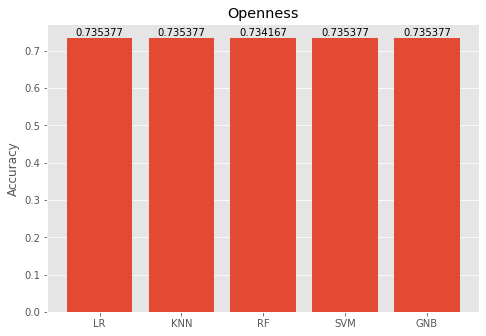

In [49]:
# Openness
lr_model_accuracy_opn = lr_model_accuracy['accuracy_opn']
knn_model_accuracy_opn = knn_model_accuracy['accuracy_opn']
rf_model_accuracy_opn = rf_model_accuracy['accuracy_opn']
svm_model_accuracy_opn = svm_model_accuracy['accuracy_opn']
gnb_model_accuracy_opn = gnb_model_accuracy['accuracy_opn']

accuracies = [lr_model_accuracy_opn, knn_model_accuracy_opn, rf_model_accuracy_opn, svm_model_accuracy_opn, gnb_model_accuracy_opn]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Accuracy')
ax.set_title('Openness')
bars = ax.bar(models, accuracies)
ax.bar_label(bars)
plt.show()

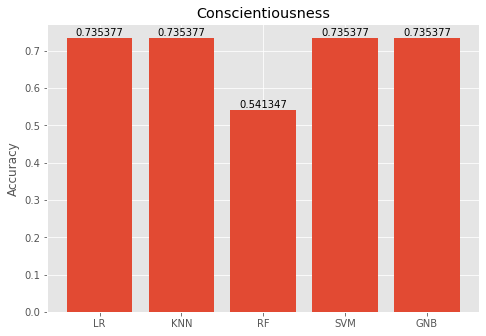

In [50]:
# Conscientiousness
lr_model_accuracy_con = lr_model_accuracy['accuracy_con']
knn_model_accuracy_con = knn_model_accuracy['accuracy_con']
rf_model_accuracy_con = rf_model_accuracy['accuracy_con']
svm_model_accuracy_con = svm_model_accuracy['accuracy_con']
gnb_model_accuracy_con = gnb_model_accuracy['accuracy_con']

accuracies = [lr_model_accuracy_opn, knn_model_accuracy_opn, rf_model_accuracy_con, svm_model_accuracy_opn, gnb_model_accuracy_opn]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Accuracy')
ax.set_title('Conscientiousness')
bars = ax.bar(models, accuracies)
ax.bar_label(bars)
plt.show()

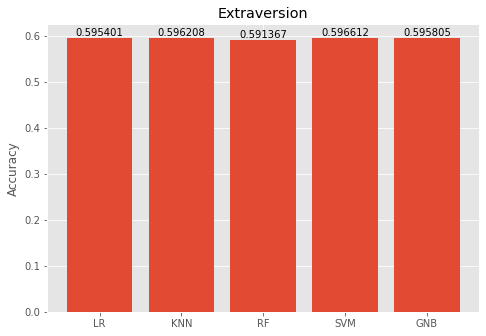

In [51]:
# Extraversion
lr_model_accuracy_ext = lr_model_accuracy['accuracy_ext']
knn_model_accuracy_ext = knn_model_accuracy['accuracy_ext']
rf_model_accuracy_ext = rf_model_accuracy['accuracy_ext']
svm_model_accuracy_ext = svm_model_accuracy['accuracy_ext']
gnb_model_accuracy_ext = gnb_model_accuracy['accuracy_ext']

accuracies = [lr_model_accuracy_ext, knn_model_accuracy_ext, rf_model_accuracy_ext, svm_model_accuracy_ext, gnb_model_accuracy_ext]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Accuracy')
ax.set_title('Extraversion')
bars = ax.bar(models, accuracies)
ax.bar_label(bars)
plt.show()

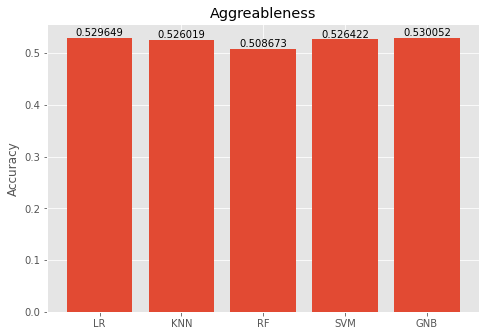

In [52]:
# Aggreableness
lr_model_accuracy_agr = lr_model_accuracy['accuracy_agr']
knn_model_accuracy_agr = knn_model_accuracy['accuracy_agr']
rf_model_accuracy_agr = rf_model_accuracy['accuracy_agr']
svm_model_accuracy_agr = svm_model_accuracy['accuracy_agr']
gnb_model_accuracy_agr = gnb_model_accuracy['accuracy_agr']

accuracies = [lr_model_accuracy_agr, knn_model_accuracy_agr, rf_model_accuracy_agr, svm_model_accuracy_agr, gnb_model_accuracy_agr]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Accuracy')
ax.set_title('Aggreableness')
bars = ax.bar(models, accuracies)
ax.bar_label(bars)
plt.show()

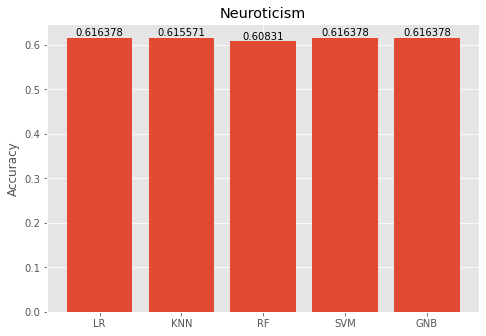

In [53]:
# Neuroticism
lr_model_accuracy_neu = lr_model_accuracy['accuracy_neu']
knn_model_accuracy_neu = knn_model_accuracy['accuracy_neu']
rf_model_accuracy_neu = rf_model_accuracy['accuracy_neu']
svm_model_accuracy_neu = svm_model_accuracy['accuracy_neu']
gnb_model_accuracy_neu = gnb_model_accuracy['accuracy_neu']

accuracies = [lr_model_accuracy_neu, knn_model_accuracy_neu, rf_model_accuracy_neu, svm_model_accuracy_neu, gnb_model_accuracy_neu]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Accuracy')
ax.set_title('Neuroticism')
bars = ax.bar(models, accuracies)
ax.bar_label(bars)
plt.show()